# Importy

In [ ]:
#! pip install matplotlib
#! pip install scikit-image

#import nibabel as nib
import numpy as np
from datetime import date
import sys
from pathlib import Path
from zipfile import ZipFile
import h5py, json
import matplotlib.pyplot as plt
import os, shutil
import pandas as pd
import random
from typing import List
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from zipfile import ZipFile

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv3DTranspose, Input, concatenate
from keras.callbacks import History

from __future__ import print_function
from sklearn.utils import class_weight
from keras.layers import ConvLSTM2D, Bidirectional, BatchNormalization, Conv3D, Cropping3D, Conv3DTranspose, ZeroPadding3D, Activation, Input, Dropout, MaxPooling3D, UpSampling3D, concatenate
from keras.models import Model

## Model

In [8]:
# str(date.today())
def uloz(filename, model, history_callback):
    model.save_weights('weights__' + str(filename) + '.h5')
    with open('history__' + str(filename)+ '.json', 'w') as f:
        json.dump(history_callback.history, f)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def weighted_binary_crossentropy(zero_weight, one_weight):
    def weighted_binary_crossentropy(y_true, y_pred):
        b_ce = K.binary_crossentropy(y_true, y_pred)
        weight_vector = y_true * one_weight + (1 - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce
        return K.mean(weighted_b_ce)
    return weighted_binary_crossentropy

def get_unet(version=1, shape=(50,50,50,1), class_weights=None):
    K.set_image_data_format('channels_last')
    inputs = Input((shape[0], shape[1], shape[2], 1))

    if(version == 1_1):
        conv1 = Conv3D(8, 3, activation='relu', padding='same')(inputs)
        conv1 = Conv3D(8, 3, activation='relu', padding='same')(conv1)
        pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

        conv2 = Conv3D(16, 3, activation='relu', padding='same')(pool1)
        conv2 = Conv3D(16, 3, activation='relu', padding='same')(conv2)
        pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
        drop2 = Dropout(0.5)(conv2)
        #bottleneck
        conv3 = Conv3D(32, 3, activation='relu', padding='same')(pool2)
        conv3 = Conv3D(32, 3, activation='relu', padding='same')(conv3)
        drop3 = Dropout(0.5)(conv3)

        up4 = Conv3D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop3))
        conv4 = Conv3D(16, 3, activation='relu', padding='same')(up4)
        conv4 = Conv3D(16, 3, activation='relu', padding='same')(conv4)

        up5 = Conv3D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop2))
        conv5 = Conv3D(8, 3, activation='relu', padding='same')(up5)
        conv5 = Conv3D(8, 3, activation='relu', padding='same')(conv5)

        conv6 = Conv3D(1, 1, activation='sigmoid')(conv5)
        model = Model(inputs=[inputs], outputs=[conv6])
        
    #MALY MODEL
    if(version == 1):
        conv1 = Conv3D(8, 3, activation='relu', padding='same')(inputs)
        conv1 = Conv3D(8, 3, activation='relu', padding='same')(conv1)
        pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

        conv2 = Conv3D(16, 3, activation='relu', padding='same')(pool1)
        conv2 = Conv3D(16, 3, activation='relu', padding='same')(conv2)
        pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
        drop2 = Dropout(0.5)(conv2)
        #bottleneck
        conv3 = Conv3D(32, 3, activation='relu', padding='same')(pool2)
        conv3 = Conv3D(32, 3, activation='relu', padding='same')(conv3)
        drop3 = Dropout(0.5)(conv3)

        up4 = Conv3D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop3))
        conv4 = Conv3D(16, 3, activation='relu', padding='same')(up4)
        conv4 = Conv3D(16, 3, activation='relu', padding='same')(conv4)

        up5 = Conv3D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop2))
        conv5 = Conv3D(8, 3, activation='relu', padding='same')(up5)
        conv5 = Conv3D(8, 3, activation='relu', padding='same')(conv5)

        conv6 = Conv3D(1, 1, activation='sigmoid')(conv5)
        model = Model(inputs=[inputs], outputs=[conv6])
    
    #UNET
    if(version == 2):
        conv1 = Conv3D(64, 3, activation='relu', padding='same')(inputs)
        conv1 = Conv3D(64, 3, activation='relu', padding='same')(conv1)
        pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

        conv2 = Conv3D(128, 3, activation='relu', padding='same')(pool1)
        conv2 = Conv3D(128, 3, activation='relu', padding='same')(conv2)
        pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
        drop2 = Dropout(0.5)(conv2)

        conv3 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool2)
        conv3 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv3)
        pool3 = MaxPooling3D(pool_size=(2, 2 ,2))(conv3)
        drop3 = Dropout(0.5)(conv3)

        conv4 = Conv3D(512, 3, activation='relu', padding='same')(pool3)
        conv4 = Conv3D(512, 3, activation='relu', padding='same')(conv4)
        pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)
        drop4 = Dropout(0.5)(conv4)
        #bottleneck
        conv5 = Conv3D(1024, 3, activation='relu', padding='same')(pool4)
        conv5 = Conv3D(1024, 3, activation='relu', padding='same')(conv5)
        drop5 = Dropout(0.5)(conv5)

        up6 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop5))
        conv6 = Conv3D(512, 3, activation = 'relu', padding = 'same')(up6)
        conv6 = Conv3D(512, 3, activation = 'relu', padding = 'same')(conv6)

        up7 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop4))
        conv7 = Conv3D(256, 3, activation='relu', padding='same')(up7)
        conv7 = Conv3D(256, 3, activation='relu', padding='same')(conv7)

        up8 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop3))
        conv8 = Conv3D(128, 3, activation='relu', padding='same')(up8)
        conv8 = Conv3D(128, 3, activation='relu', padding='same')(conv8)

        up9 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop2))
        conv9 = Conv3D(64, 3, activation='relu', padding='same')(up9)
        conv9 = Conv3D(64, 3, activation='relu', padding='same')(conv9)

        conv10 = Conv3D(1, 1, activation='sigmoid')(conv9)
        model = Model(inputs=[inputs], outputs=[conv10])

    # DEEP NET
    if(version == 3):
        conv1 = Conv3D(8, 3, activation='relu', padding='same')(inputs)
        conv1 = Conv3D(8, 3, activation='relu', padding='same')(conv1)
        pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

        conv2 = Conv3D(16, 3, activation='relu', padding='same')(pool1)
        conv2 = Conv3D(16, 3, activation='relu', padding='same')(conv2)
        pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
        drop2 = Dropout(0.5)(conv2)

        conv3 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(pool2)
        conv3 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv3)
        pool3 = MaxPooling3D(pool_size=(2, 2 ,2))(conv3)
        drop3 = Dropout(0.5)(conv3)

        conv4 = Conv3D(64, 3, activation='relu', padding='same')(pool3)
        conv4 = Conv3D(64, 3, activation='relu', padding='same')(conv4)
        pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)
        drop4 = Dropout(0.5)(conv4)

        conv5 = Conv3D(128, 3, activation='relu', padding='same')(pool4)
        conv5 = Conv3D(128, 3, activation='relu', padding='same')(conv5)
        pool5 = MaxPooling3D(pool_size=(2, 2, 2))(conv5)
        drop5 = Dropout(0.5)(conv5)

        conv6 = Conv3D(256, 3, activation='relu', padding='same')(pool5)
        conv6 = Conv3D(256, 3, activation='relu', padding='same')(conv6)
        pool6 = MaxPooling3D(pool_size=(2, 2, 2))(conv6)
        drop6 = Dropout(0.5)(conv6)
        
        conv7 = Conv3D(512, 3, activation='relu', padding='same')(pool6)
        conv7 = Conv3D(512, 3, activation='relu', padding='same')(conv7)
        pool7 = MaxPooling3D(pool_size=(2, 2, 2))(conv7)
        drop7 = Dropout(0.5)(conv7)
        
        #bottleneck
        conv8 = Conv3D(1024, 3, activation='relu', padding='same')(pool7)
        conv8 = Conv3D(1024, 3, activation='relu', padding='same')(conv8)
        drop8 = Dropout(0.5)(conv8)

        up9 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop8))
        conv9 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up9)
        conv9 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

        up10 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop7))
        conv10 = Conv3D(256, 3, activation='relu', padding='same')(up10)
        conv10 = Conv3D(256, 3, activation='relu', padding='same')(conv10)

        up11 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop6))
        conv11 = Conv3D(128, 3, activation='relu', padding='same')(up11)
        conv11 = Conv3D(128, 3, activation='relu', padding='same')(conv11)

        up12 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop5))
        conv12 = Conv3D(64, 3, activation='relu', padding='same')(up12)
        conv12 = Conv3D(64, 3, activation='relu', padding='same')(conv12)

        up13 = Conv3D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop4))
        conv13 = Conv3D(32, 3, activation='relu', padding='same')(up13)
        conv13 = Conv3D(32, 3, activation='relu', padding='same')(conv13)

        up14 = Conv3D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop3))
        conv14 = Conv3D(16, 3, activation='relu', padding='same')(up14)
        conv14 = Conv3D(16, 3, activation='relu', padding='same')(conv14)
        
        up15 = Conv3D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop2))
        conv15 = Conv3D(8, 3, activation='relu', padding='same')(up15)
        conv15 = Conv3D(8, 3, activation='relu', padding='same')(conv15)

        conv16 = Conv3D(1, 1, activation='sigmoid')(conv15)
        model = Model(inputs=[inputs], outputs=[conv16])

    return model

## Ircad

In [10]:
# !pip install sed3 loguru pydicom SimpleITK imma ruamel.yaml pandas # io3d
# !pip install imma@git+https://github.com/mjirik/imma
# !pip install io3d@git+https://github.com/mjirik/io3d # installace z přímo z githubu
# !pip install loguru
# !pip install tqdm
import requests
from loguru import logger
logger.enable("io3d")
logger.disable("io3d")
from tqdm import tqdm
from numbers import Number
from typing import Optional

import io3d
import io3d.datasets
from random import shuffle
from typing import Tuple
from PIL import Image
# import skimage.transform

In [11]:
def classes_from_coco(annotation_file:Path):
    with open(annotation_file) as f:
        ann = json.load(f)
    _, cfg_classes = zip(*sorted([(cat["id"], cat["name"]) for cat in ann["categories"]]))
    return cfg_classes

def mywget(url, fname, force=False):
    fname = Path(fname)
    if fname.exists() and ~force:
        print(f"File already exists. Use force=True to owerwrite.")
        return
    fname.parent.mkdir(parents=True, exist_ok=True)
    response = requests.get(url, stream=True)
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(fname, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")

def window(
    data3d: np.ndarray,
    vmin: Optional[Number] = None,
    vmax: Optional[Number] = None,
    center: Optional[Number] = None,
    width: Optional[Number] = None,
    vmin_out: Optional[Number] = 0,
    vmax_out: Optional[Number] = 255,
    dtype=np.uint8,
):
    """
    Rescale input ndarray and trim the outlayers. Used for image intensity windowing.
    :param data3d: ndarray with numbers
    :param vmin: minimal input value. Skipped if center and width is given.
    :param vmax: maximal input value. Skipped if center and width is given.
    :param center: Window center
    :param width: Window width
    :param vmin_out: Output mapping minimal value
    :param vmax_out: Output mapping maximal value
    :param dtype: Output dtype
    :return:
    """
    if width and center:
        vmin = center - (width / 2.0)
        vmax = center + (width / 2.0)

    # logger.debug(f"vmin={vmin}, vmax={vmax}")
    k = float(vmax_out - vmin_out) / (vmax - vmin)
    q = vmax_out - k * vmax
    # logger.debug(f"k={k}, q={q}")
    data3d_out = data3d * k + q

    data3d_out[data3d_out > vmax_out] = vmax_out
    data3d_out[data3d_out < vmin_out] = vmin_out

    return data3d_out.astype(dtype)


def preprocess(imgs, is_mask=False, img_rows=256, img_cols=256):
    if not is_mask:
      imgs = window(imgs, center=40, width=400, vmin_out=0, vmax_out=255, dtype=np.uint8)

    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = skimage.transform.resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    if is_mask:
        imgs_p = (imgs_p > 0).astype('float32')
    else:
        imgs_p = imgs_p.astype('float32') / 255.
    return imgs_p

def image_generator(ct_ids, promenne, shape):
   promenne = np.array(promenne[1:])
   new_voxelsize_mm = [1,1,1]
   data_raw = np.zeros((shape[0],shape[1],shape[2],shape[3],shape[4])) #(1, 325, 304, 600, 1)
   data_mask = np.zeros((shape[0],shape[1],shape[2],shape[3],shape[4])) #(batch_size, 325, 304, 600, num_cannels)

   while True:
    dataset = '3Dircadb1'
    io3d.datasets.get_dataset_path("3Dircadb1", "data3d", 1)
    #print(io3d.datasets.get_dataset_path("3Dircadb1", "data3d", 1))
    for k in range(shape[0]):
      ct_id = np.random.choice(ct_ids, size = 1)
      # print(ct_id)
      raw_p = io3d.read(io3d.datasets.get_dataset_path("3Dircadb1", "data3d", ct_id[0]))      # naprahovat masky na polovinu mezi min a max > 0/1 namisto 0/255#                                         # venoussystem, artery, portalvein
      dataRaw  = window(raw_p.data3d,  center=40, width=400)
      dataRaw  = io3d.image_manipulation.resize_to_mm(dataRaw,  voxelsize_mm=raw_p.voxelsize_mm, new_voxelsize_mm=new_voxelsize_mm)
      masky = []    
      for i in range(len(promenne)): # scitani masek
        maskp = io3d.read_dataset("3Dircadb1", promenne[i], ct_id[0]) # segmentacni maska  ###############
        mask = window(maskp.data3d, center=40, width=400)
        mask = io3d.image_manipulation.resize_to_mm(mask, voxelsize_mm=raw_p.voxelsize_mm, new_voxelsize_mm=new_voxelsize_mm)
        masky.append(mask)       
      dataMask = np.sum(masky, axis=0)

      xscale = random.randrange(0,dataRaw.shape[0]-shape[1])
      yscale = random.randrange(0,dataRaw.shape[1]-shape[2])
      zscale = random.randrange(0,dataRaw.shape[2]-shape[3])
      #angle = random.randrange(-10,10)  # scipy.nd.image.rotate(array, uhel, axis)
      dataRaw = dataRaw[xscale:xscale+shape[1],yscale:yscale+shape[2],zscale:zscale+shape[3]]
      dataMask = dataMask[xscale:xscale+shape[1],yscale:yscale+shape[2],zscale:zscale+shape[3]]

      prah = int(dataMask.mean()) #prahovani kvuli rozostreni masek
      dataMask[dataMask<=prah] = 0
      dataMask[dataMask>prah] = 1
        
      for lay in range(shape[4]):
        data_raw[k,:,:,:,lay] = dataRaw/255
        data_mask[k,:,:,:,lay] = dataMask
    yield data_raw, data_mask

In [12]:
io3d.datasets.DATASET_PATH_STRUCTURE["3Dircadb1"]["_"] = "medical/orig/3Dircadb1/3Dircadb1.{id}/MASKS_DICOM/{data_type}/"
io3d.datasets.DATASET_PATH_STRUCTURE["3Dircadb1"]["data3d"] = "medical/orig/3Dircadb1/3Dircadb1.{id}/PATIENT_DICOM/"
io3d.datasets.get_dataset_path("3Dircadb1", "data3d", 1)

pallete = np.array([
    [255, 0, 0],    # index 1 is red
    [0, 255, 0],    # index 2 is green
    [0, 0, 255],    # index 3 is blue
    [255, 255, 0],  # spare indices
    [0,255, 255],
    [255, 80, 100],
    [100, 255, 100],
])
palette_names = ['red', 'green', 'blue', 'light-blue', 'pink', 'lime']

# Data Generator

In [13]:
#     DICOM_file - NEW_voxelsize = [1,1,1]        ORIG_data_shape      ORIG_data_voxelsize   RESIZED_data_shape
# ----------------------------------------------------------------------------------------------------------------------------------
s1 = ['artery','portalvein','venoussystem']    # (3, 129, 512, 512)   # [1.6, 0.57, 0.57]   # (207, 292, 292)
s2 = ['portalvein','venacava']                 # (2, 172, 512, 512)   # [1.6, 0.78, 0.78]   # (276, 401, 401)
#s3 = ['portalvein','venacava'] # data = maska # (2, 200, 512, 512)   # [1.2, 0.62, 0.62]   # (250, 320, 320)
s4 = ['artery','portalvein','venoussystem']    # (3, 91,  512, 512)   # [2.0, 0.74, 0.74]   # (182, 381, 381)
s5 = ['artery','portalvein','venoussystem']    # (3, 139, 512, 512)   # [1.6, 0.78, 0.78]   # (223, 401, 401)
s6 = ['artery','portalvein','venoussystem']    # (3, 135, 512, 512)   # [1.6, 0.78, 0.78]   # (217, 401, 401)
s7 = ['artery','portalvein','venoussystem']    # (3, 151, 512, 512)   # [1.6, 0.78, 0.78]   # (242, 401, 401)
s8 = ['artery','portalvein','venoussystem']    # (3, 124, 512, 512)   # [1.6, 0.56, 0.56]   # (199, 288, 288)
s9 = ['artery','portalvein','venoussystem']    # (3, 111, 512, 512)   # [2.0, 0.87, 0.87]   # (222, 448, 448)
# s10 = ['venacava', 'portalvein'] # Problem  'portalvein1',   # (1, 225, 512, 512)   # [1.6, 0.73, 0.73]   # (196, 377, 377)
s11 = ['artery','portalvein','venacava']       # (3, 132, 512, 512)   # [1.6, 0.72, 0.72]   # (212, 369, 369)
s12 = ['artery','portalvein','venacava']       # (3, 260, 512, 512)   # [1.0, 0.68, 0.68]   # (260, 349, 349)
s13 = ['artery','portalvein','venacava']       # (3, 122, 512, 512)   # [1.6, 0.67, 0.67]   # (196, 344, 344)
s14 = ['portalvein','venoussystem']                # (2, 113, 512, 512)   # [1.6, 0.72, 0.72]   # (181, 369, 369)
s15 = ['portalvein','venoussystem']            # (2, 125, 512, 512)   # [1.6, 0.78, 0.78]   # (201, 401, 401)
s16 = ['portalvein','venoussystem']            # (2, 155, 512, 512)   # [1.6, 0.69, 0.69]   # (249, 358, 358)
s17 = ['artery','portalvein','venoussystem']   # (3, 119, 512, 512)   # [1.6, 0.74, 0.74]   # (191, 381, 381)
s18 = ['portalvein','venacava']                # (2, 74,  512, 512)   # [2.5, 0.74, 0.74]   # (185, 381, 381)
s19 = ['portalvein','venoussystem']            # (2, 124, 512, 512)   # [4.0, 0.70, 0.70]   # (496, 360, 360)
# s20 = ['artery','portalvein','venacava']# spatne segmentovano       # (3, 225, 512, 512)   # [2.0, 0.81, 0.81]   # (450, 415, 415)

portalvein = [1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19]     # portalvein - zdola do jater
artery = [1, 4, 5, 6, 7, 8, 9, 11, 12, 13, 17] 
venacava = [2, 11, 12, 13, 18]                                      # venacava - shora do jater
venoussystem = [1, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 19]
cevy1 = [1, 4, 5, 6, 7, 8, 9, 17]      # artery, portalvein, venoussystem
cevy2 = [2, 11, 12, 13, 18]   # portalvein, venacava
cevy3 = [1, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 19]   # portalvein, venoussystem

s_artery = ['artery','artery'] # format [jmeno_modelu, slozky ...]
s_portalvein = ['portalvein', 'portalvein']
s_venacava = ['venacava', 'venacava']
s_venoussystem = ['venoussystem', 'venoussystem']
s_cevy1 = ['cevy1', 'artery','portalvein','venoussystem']  
s_cevy2 = ['cevy2', 'portalvein','venacava']    
s_cevy3 = ['cevy3', 'portalvein','venoussystem'] 

In [25]:
batch_size = 5
hloubka = 128        # 128
img_rows = 256       # 256
img_cols = 256       # 256
number_channels = 1
smooth = 1.

ct_ids_train = artery[0:-1]
ct_ids_test = artery[-1:]
promenne = s_artery
#######################################################
size = np.array([batch_size, hloubka, img_rows, img_cols, number_channels])
train_generator = image_generator(ct_ids_train, promenne, shape=size)
test_generator = image_generator(ct_ids_test, promenne, shape=size)

In [15]:
x, y = next(test_generator)


Train generator ukazka [x, y]: 
(2, 128, 256, 256, 1) float64 0.0 1.0
(2, 128, 256, 256, 1) float64 0.0 1.0


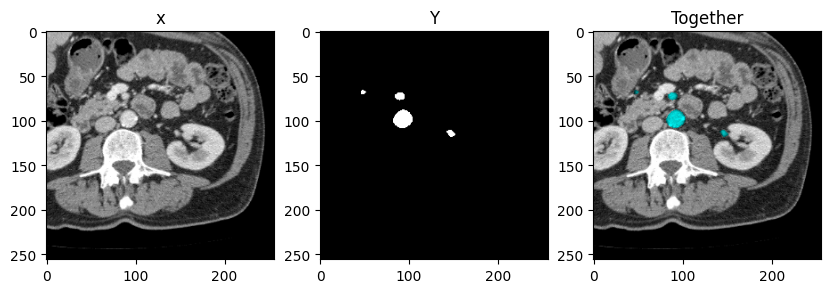

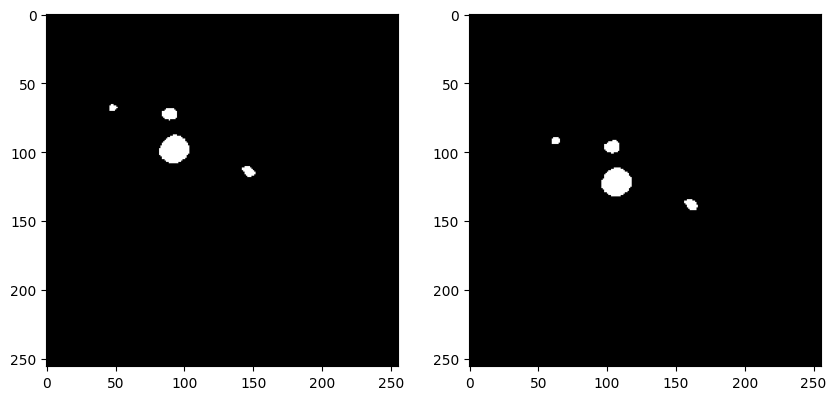

In [16]:
soubor = 0
vrstva = 100
##################################################################
print('\nTrain generator ukazka [x, y]: ')
print(x.shape, x.dtype, np.min(x), np.max(x))  # (batch_size, num_rows, num_cols, num_channels)
print(y.shape, y.dtype, np.min(y), np.max(y))  # (batch_size, num_rows, num_cols, num_channels)

data = x[soubor,vrstva,:,:,0] * 255
maska = y[soubor,vrstva,:,:,0] * 255
img = np.zeros((*data.shape[:],3),dtype=np.uint8)
for i in range(3):    
    img[:,:,i] = data
img[:,:,0][maska>200] = pallete[0,1]    
    
plt.subplot(131)
plt.imshow(x[soubor,vrstva,:,:,0], cmap='gray')
#plt.colorbar()
plt.title("x")
plt.subplot(132)
plt.imshow(y[soubor,vrstva,:,:,0], cmap='gray')
#plt.colorbar()
plt.title("Y")
plt.subplot(133)
plt.imshow(img)
#plt.colorbar()
plt.title("Together")

plt.gcf().set_size_inches(10, 10)
plt.show()

plt.figure(figsize=(10,5))
for i in range(batch_size):
    plt.subplot(1,batch_size,i+1)
    plt.imshow(y[i,vrstva,:,:,0], cmap='gray')
plt.show()

In [17]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y.flatten()), y=y.flatten())
ztrata = weighted_binary_crossentropy(class_weights[0], class_weights[1])

print('X (min, max): [' + str(np.min(x)) + ', ' + str(np.max(x)) + ']')
print('Y (unique): ' + str(np.unique(y)) + '\n')
print('Kontrola fitt funkce: ' + str(ztrata(y[0,:,:,:,:], y[0,:,:,:,:])))
print('Weights: ' + str([format(w, '.2f') for w in class_weights]))

X (min, max): [0.0, 1.0]
Y (unique): [0. 1.]



2024-05-06 02:39:39.540595: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43334 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:e1:00.0, compute capability: 8.6


Kontrola fitt funkce: tf.Tensor(0.0, shape=(), dtype=float64)
Weights: ['0.51', '45.27']


## Nastavení modelu

In [21]:
file_model_in  = ''   # '/weights__' + promenne[0] + '.h5'  #---> '' nebo '/weights__' + promenne[0] + '.h5'
file_model_out = promenne[0]

print('file_model_in:\t' + str(file_model_in))
print('file_model_out:\t' + str(file_model_out))

class_weights = [0.5, 45] 
learning_rate = 0.001
metriky = [dice_coef, "accuracy"]
model = get_unet(version=3, shape=size[1:])

file_model_in:	/weights__artery.h5
file_model_out:	artery


In [22]:
train_generator = image_generator(ct_ids_train, promenne, shape=size)
test_generator = image_generator(ct_ids_test, promenne, shape=size)

### Vytvoření modelu

In [23]:
history_callback = History()
model.compile(optimizer='adam', loss=weighted_binary_crossentropy(class_weights[0], class_weights[1]), metrics=metriky)
model.optimizer.learning_rate = learning_rate
print('Optimater: ' + str(model.optimizer.learning_rate) + '\n')

if file_model_in == '':
    print('Vytvoren novy model')    
else:    
    print('Nahran model: ' + str(os.getcwd() +  file_model_in))
    model.load_weights(os.getcwd() +  file_model_in)

Optimater: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

Nahran model: /auto/brno2/home/romova9/weights__artery.h5


### Trénovat model

In [ ]:
epochy = 20
file_out = artery
history = []
#####################################
i = 0
while True :
    i = i + 1
    print('\nTrenován:' + str(i))
    model.fit(train_generator, epochs= epochy, steps_per_epoch=250, callbacks=[history_callback])   #zvetsit pocet dat v jedne epose
    if history_callback.history['dice_coef'][-1] > 0.9:
        break


Trenován:1
Epoch 1/20


2024-05-06 02:40:36.351403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-05-06 02:41:30.083557: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x148a9025f690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-06 02:41:30.083605: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-05-06 02:41:30.146705: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-06 02:41:32.251864: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  8/250 [..............................] - ETA: 37:20 - loss: 0.0339 - dice_coef: 0.5048 - accuracy: 0.9848

### Uložení modelu

In [76]:
uloz(file_model_out, model, history_callback)

In [30]:
model.count_params() # model.summary()

19305

### Vyhodnocení modelu

In [28]:
x,y = next(train_generator)
vyhodnoceni = model.evaluate(x=x, y=y)
predpoved = model.predict(x=x)
print('Pocet parametru: '+str(model.count_params()))
print(predpoved.shape)

1/1 [==============================] - 6s 6s/step
(5, 128, 256, 256, 1)


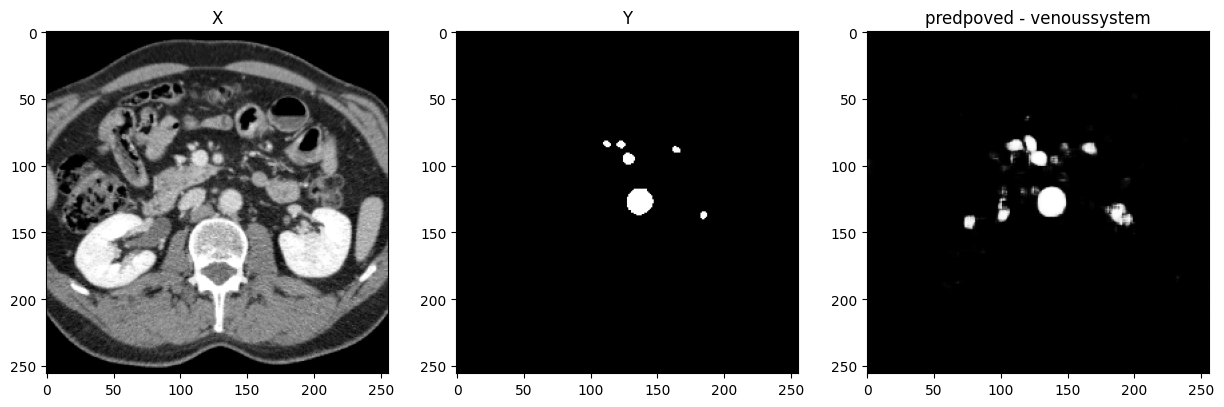

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


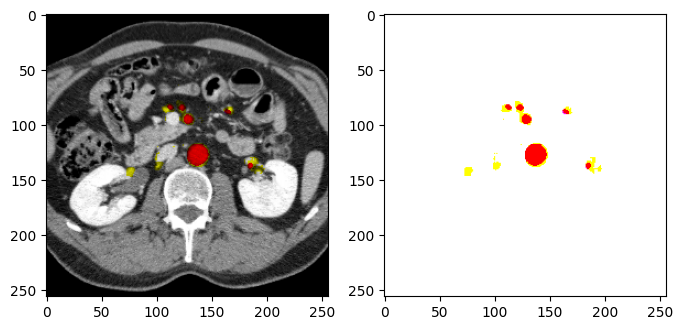

In [29]:
soubor = 0
vrstva = 110
##############################################################
plt.subplot(131)
plt.imshow(x[soubor,vrstva,:,:,0], cmap='gray')
plt.title("X")
plt.subplot(132)
plt.imshow(y[soubor,vrstva,:,:,0], cmap='gray')
plt.title("Y")
plt.subplot(133)
plt.imshow(predpoved[soubor,vrstva,:,:,0], cmap='gray')
plt.title("predpoved - venoussystem")

plt.gcf().set_size_inches(15,5)
plt.show()

pic = x[soubor,vrstva,:,:,0]*255
m_y = y[soubor,vrstva,:,:,0]*255
m_p = predpoved[soubor,vrstva,:,:,0]*255

im = np.zeros((*pic.shape[0:3],3),dtype=np.uint8)
for v in range(3):
  im[:,:,v] = pic

im[:,:,1][m_y>150] = pallete[1,0]
im[:,:,2][m_p>150] = pallete[2,0]

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(im)

mas = np.ones((*pic.shape[0:3],3),dtype=np.uint8)*256

mas[:,:,1][m_y>200] = pallete[1,0]
mas[:,:,2][m_p>200] = pallete[2,0]

plt.subplot(122)
plt.imshow(mas)